In [115]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import prim
import seaborn as sns
from sklearn import mixture
import os
from clustering_and_prim_tools import *

In [116]:
%matplotlib inline

In [117]:
myfolder = "C:/Users/WB451855/OneDrive - WBG/!infra_needs_data/coastal_protection_output_data/"

In [158]:
mydata = pd.read_csv(myfolder+"global_output.csv")

In [147]:
mydata.columns

Index(['locationid', 'locationname', 'rcp', 'ada', 'ssp', 'adacost',
       'riverprotection', 'time', 'rslr', 'par', 'pop_below_h100',
       'riverdike_cost', 'riverdike_maintenance_cost', 'seadike_cost',
       'seadike_maintenance_cost', 'seafloodcost', 'surge_barrier_cost',
       'surge_barrier_maintenance_cost', 'protection_investment_cost',
       'protection_maintenance_cost'],
      dtype='object')

In [159]:
mydata = mydata.set_index(['rcp', 'ada', 'ssp', 'adacost','riverprotection'])

In [149]:
mydata.time.unique()

array([2010, 2015, 2020, 2025, 2030, 2035, 2040, 2045, 2050, 2055, 2060,
       2065, 2070, 2075, 2080, 2085, 2090, 2095, 2100], dtype=int64)

In [150]:
def discount_sum_over_5_years(row,name,d):
    return np.sum([row[name]/5*(1+d)**(1-(year-2010)) for year in np.arange(row["time"]-4,row["time"])])

In [160]:
d = 0.03

In [161]:
mydata['protection_investment_cost_disc'] = mydata.apply(lambda y:discount_sum_over_5_years(y,"protection_investment_cost",d),axis=1)
mydata['protection_maintenance_cost_disc'] = mydata.apply(lambda y:discount_sum_over_5_years(y,"protection_maintenance_cost",d),axis=1)
mydata['seafloodcost_disc'] = mydata.apply(lambda y:discount_sum_over_5_years(y,"seafloodcost",d),axis=1)

In [138]:
#newdata = mydata.loc[mydata.time<2035,:]

In [162]:
newdata = mydata.set_index('time', append=True)[['protection_investment_cost_disc','protection_maintenance_cost_disc','seafloodcost_disc']]

In [163]:
newdatacum = newdata.sum(level=['rcp', 'ada', 'ssp', 'adacost','riverprotection'])

In [10]:
sns.set_context("poster",rc={"font.size": 28})
sns.set_style("whitegrid")

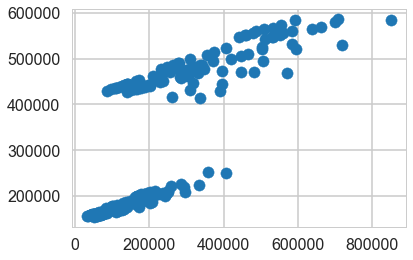

In [45]:
plt.scatter(newdatacum.protection_investment_cost_disc,newdatacum.protection_maintenance_cost_disc)

In [164]:
newdatacum["tot_cost"] = newdatacum.protection_investment_cost_disc+newdatacum.protection_maintenance_cost_disc

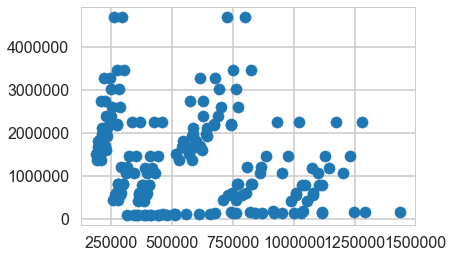

In [47]:
plt.scatter(newdatacum.tot_cost,newdatacum.seafloodcost_disc)

In [49]:
oois = ['tot_cost','seafloodcost_disc']

data = np.array([[newdatacum[oois[0]][0],newdatacum[oois[1]][0]]])
for i in range(1,len(newdatacum.index)):
    data = np.concatenate((data,np.array([[newdatacum[oois[0]][i],newdatacum[oois[1]][i]]])))

data_norm = normalize(data)

In [50]:
inputs = newdatacum.reset_index()[['rcp', 'ada', 'ssp', 'adacost','riverprotection']]

In [54]:
n_clusters = 6
f_value = 0.5
seuil = 1.2

In [55]:
dummy = get_prim(n_clusters, f_value, data,oois[0],oois[1],inputs,data_norm)
boxes = dummy[0]
df = dummy[1]

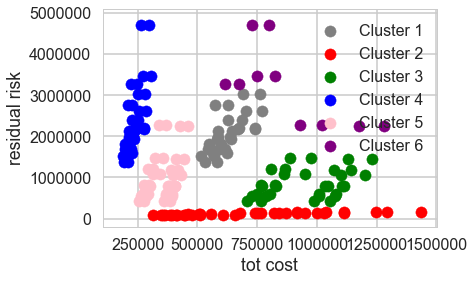

In [56]:
mycolors = ["grey","red","green","blue","pink","purple"]
for (i,subdf) in df.groupby("class"):

    plt.scatter(subdf.tot_cost,subdf.seafloodcost_disc,label="Cluster {}".format(i),c=mycolors[i-1])
plt.legend()
plt.xlabel("tot cost")
plt.ylabel("residual risk")

In [57]:
boxes[0].limits

,min,max,qp values
ada,"{Constant Protection Levels, Constant Rel. Flo...","{Constant Protection Levels, Constant Rel. Flo...",9.175853e-10
adacost,{High Adaptation Unit Cost},{High Adaptation Unit Cost},3.477975e-07


In [58]:
boxes[1].limits

,min,max,qp values
ada,{CBA Protection},{CBA Protection},6.871948e-26


In [59]:
boxes[2].limits

,min,max,qp values
ada,"{Constant Abs. Flood Risk, Risk intolerance}","{Constant Abs. Flood Risk, Risk intolerance}",4.628203e-11
adacost,{High Adaptation Unit Cost},{High Adaptation Unit Cost},3.328461e-08


In [60]:
boxes[3].limits

,min,max,qp values
ada,"{Constant Protection Levels, Constant Rel. Flo...","{Constant Protection Levels, Constant Rel. Flo...",4.722366e-15
adacost,{Low Adaptation Unit Cost},{Low Adaptation Unit Cost},1.455192e-11


In [61]:
boxes[4].limits

,min,max,qp values
ada,"{Constant Abs. Flood Risk, Risk intolerance}","{Constant Abs. Flood Risk, Risk intolerance}",4.722366e-15
adacost,{Low Adaptation Unit Cost},{Low Adaptation Unit Cost},1.455192e-11


In [62]:
boxes[5].limits

,min,max,qp values
ssp,{SSP5},{SSP5},0.000352
adacost,{High Adaptation Unit Cost},{High Adaptation Unit Cost},0.009780
rcp,"{RCP 8.5 (High ice melting), RCP 4.5 (Medium i...","{RCP 8.5 (High ice melting), RCP 4.5 (Medium i...",0.076404
ada,"{Constant Abs. Flood Risk, Constant Protection...","{Constant Abs. Flood Risk, Constant Protection...",0.227249


In [65]:
forprim = newdatacum[['tot_cost','seafloodcost_disc']].sum(axis=1).reset_index().rename(columns={0:"all_costs"})

In [67]:
forprim.all_costs.describe()

count    1.800000e+02
mean     1.956612e+06
std      1.039750e+06
min      4.119737e+05
25%      1.139432e+06
50%      1.856185e+06
75%      2.577746e+06
max      5.510730e+06
Name: all_costs, dtype: float64

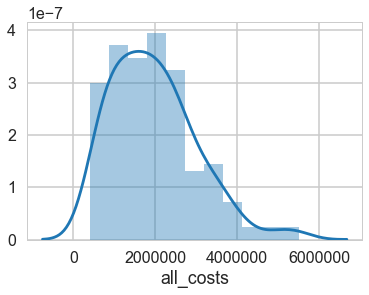

In [68]:
sns.distplot(forprim.all_costs)

In [72]:
forprim.ada.unique()

array(['CBA Protection', 'Constant Abs. Flood Risk',
       'Constant Protection Levels', 'Constant Rel. Flood Risk',
       'Risk intolerance'], dtype=object)

In [74]:
adadict = {'CBA Protection':'CBA', 'Constant Abs. Flood Risk':"c_abs",
       'Constant Protection Levels':'c', 'Constant Rel. Flood Risk':'c_rel',
       'Risk intolerance':'int'}

In [75]:
forprim['ada'] = forprim.ada.replace(adadict)

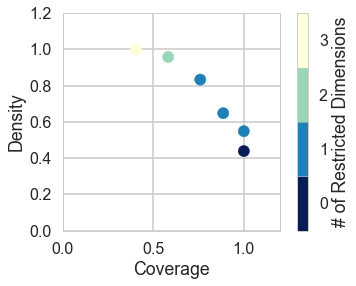

In [87]:
p = prim.Prim(forprim[['rcp', 'ada', 'ssp', 'adacost','riverprotection']], forprim.all_costs,\
              threshold=2.0e+06, threshold_type=">")

box = p.find_box()
box.show_tradeoff();

In [88]:
box.select(3)
print(box.coverage,box.density)
box.limits

0.759493670886 0.833333333333


,min,max,qp values
ada,"{c_rel, c}","{c_rel, c}",6.131459e-12


In [177]:
diff = newdatacum.tot_cost.unstack("ada")[['Risk intolerance','CBA Protection']].diff(axis=1)

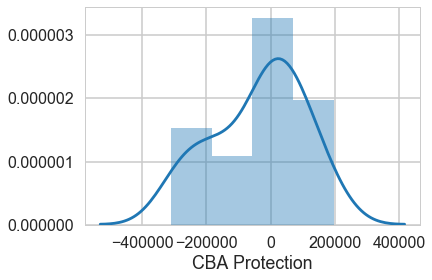

In [178]:
sns.distplot(diff['CBA Protection'])

In [168]:
forprim=diff['CBA Protection'].reset_index()

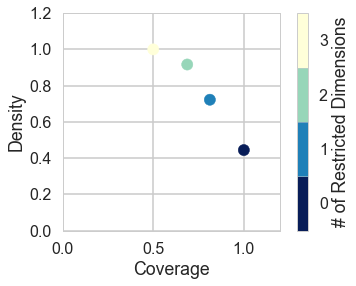

In [179]:
p = prim.Prim(forprim[['rcp', 'ssp', 'adacost','riverprotection']], forprim['CBA Protection'],\
              threshold=1, threshold_type=">")

box = p.find_box()
box.show_tradeoff();

In [180]:
box.select(1)
print(box.coverage,box.density)
box.limits

0.8125 0.722222222222


,min,max,qp values
adacost,{Low Adaptation Unit Cost},{Low Adaptation Unit Cost},0.016242


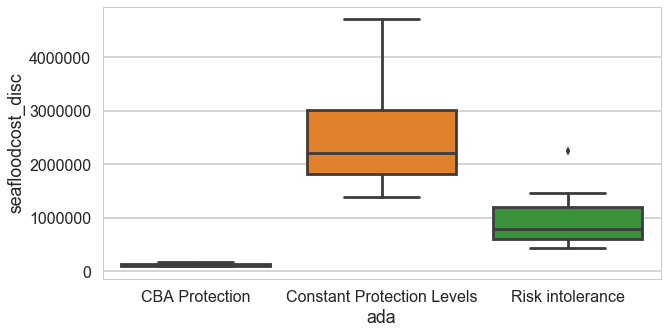

In [181]:
toplot = newdatacum.reset_index()
toplot = toplot.loc[(toplot.ada!='Constant Abs. Flood Risk')&(toplot.ada!='Constant Rel. Flood Risk'),:]

fig, ax = plt.subplots()
sns.boxplot(x='ada',y='seafloodcost_disc',data=toplot,ax=ax)
fig.set_size_inches(10, 5)

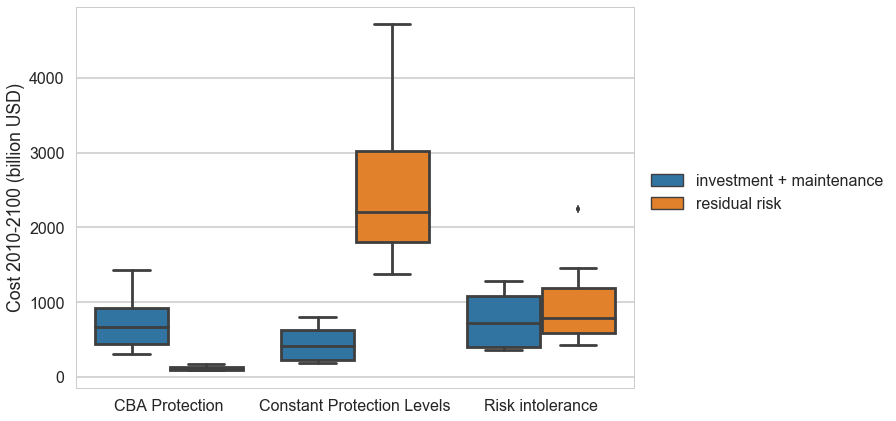

In [195]:
toplot = newdatacum[['tot_cost','seafloodcost_disc']]
toplot.columns.name="costtype"
toplot = toplot.stack()
toplot.name = "value"
toplot = toplot.reset_index()
toplot = toplot.loc[(toplot.ada!='Constant Abs. Flood Risk')&(toplot.ada!='Constant Rel. Flood Risk'),:]
toplot["costtype"] = toplot["costtype"].replace({'tot_cost':'investment + maintenance','seafloodcost_disc':'residual risk'})
toplot['value'] = 10**(-3)*toplot.value

fig, ax = plt.subplots()
sns.boxplot(x='ada',y='value', hue= 'costtype', data=toplot,ax=ax)
fig.set_size_inches(10, 7)
ax.set_xlabel("")
ax.set_ylabel("Cost 2010-2100 (billion USD)")
plt.legend(title="",bbox_to_anchor=(1.005, 0.6))

#plt.savefig("coastal_2100_0pc.png",ddpi=300,bbox_inches="tight")
#plt.savefig("coastal_2100_0pc.pdf")

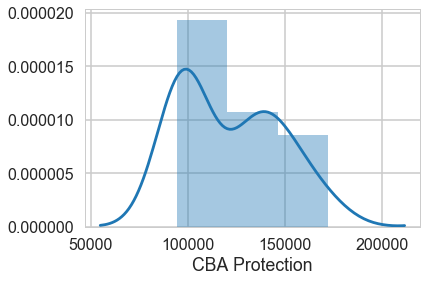

In [187]:
sns.distplot(newdatacum.seafloodcost_disc.unstack("ada")['CBA Protection'])

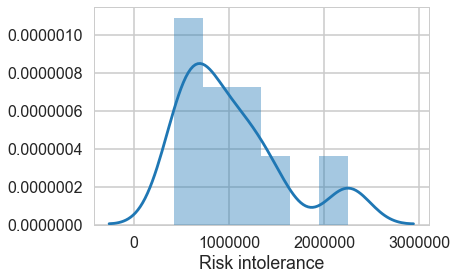

In [186]:
sns.distplot(newdatacum.seafloodcost_disc.unstack("ada")['Risk intolerance'])

In [191]:
forprim = newdatacum.seafloodcost_disc.unstack("ada")['CBA Protection'].reset_index()

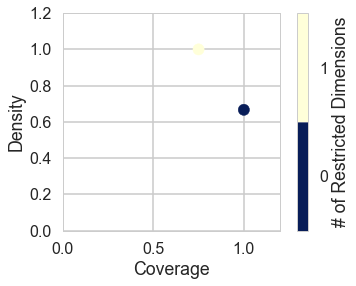

In [193]:
p = prim.Prim(forprim[['rcp', 'ssp', 'adacost','riverprotection']], forprim['CBA Protection'],\
              threshold=100000, threshold_type=">")

box = p.find_box()
box.show_tradeoff();

In [194]:
box.select(1)
print(box.coverage,box.density)
box.limits

0.75 1.0


,min,max,qp values
adacost,{High Adaptation Unit Cost},{High Adaptation Unit Cost},0.000677
